In [16]:
#deal with tensors
import torch
import spacy
from torchtext.legacy import data
import torchtext.vocab

In [17]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True

In [18]:
nlp = spacy.load("de_dep_news_trf")

In [19]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float)
fields = [(None, None),(None, None),(None, None),(None, None),(None, None),(None, None),
          ('label', LABEL),
          (None, None),(None, None),(None, None),(None, None),(None, None),(None, None),
          ('text',TEXT)]

/home/stefan/.virtualenvs/diplom-code-env/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [20]:
# loading custom dataset
training_data=data.TabularDataset(path = 'protocols/labelled/only_lockdown.csv',format = 'csv',fields = fields,skip_header = True,
                                  csv_reader_params={'delimiter': '\t', 'quotechar': None})

In [21]:
all_samples = [e for e in training_data.examples]

In [22]:
# Pre-processing
# to lower case to match with vector embeddings
tmp = []
for sample in all_samples:
    text = getattr(sample, 'text')
    text = [s.lower() for s in text]
    setattr(sample, 'text', text)

positive = [e for e in all_samples if getattr(e, 'label') == '+']
negative = [e for e in all_samples if getattr(e, 'label') == '-']
neutral = [e for e in all_samples if getattr(e, 'label') == 'o']


In [23]:
#initialize glove embeddings
# the custom vectors we use in de_glove_deepsetai.txt have 300 dimensions
de_embeddings = torchtext.vocab.Vectors(name = 'vectors/de_glove_deepsetai.txt')
TEXT.build_vocab(training_data,min_freq=1,vectors = de_embeddings)
LABEL.build_vocab(training_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))

#Word dictionary
print(TEXT.vocab.stoi)

Size of TEXT vocabulary: 3384
Size of LABEL vocabulary: 3
[(',', 1345), ('die', 595), ('.', 508), ('der', 464), ('und', 457), ('lockdown', 380), ('\xa0', 310), ('in', 251), ('–', 211), ('den', 201)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f712463f3d0>>, {'<unk>': 0, '<pad>': 1, ',': 2, 'die': 3, '.': 4, 'der': 5, 'und': 6, 'lockdown': 7, '\xa0': 8, 'in': 9, '–': 10, 'den': 11, 'das': 12, 'es': 13, 'ist': 14, 'dass': 15, 'auch': 16, 'i': 17, 'm': 18, 'wir': 19, 'für': 20, 'des': 21, ':': 22, 'haben': 23, 'nicht': 24, 'hat': 25, 'sie': 26, 'zu': 27, 'von': 28, 'lockdowns': 29, 'sind': 30, 'dem': 31, 'ich': 32, 'mit': 33, '-': 34, 'zweiten': 35, 'eine': 36, 'ein': 37, 'einen': 38, 'noch': 39, 'jetzt': 40, 'wie': 41, 'aber': 42, 'wird': 43, 'sich': 44, 'vor': 45, 'werden': 46, 'auf': 47, 'um': 48, 'diese': 49, '„': 50, 'als': 51, 'so': 52, 'an': 53, 'durch': 54, 'am': 55, 'ja': 56, '“': 57, 'schon': 58, 'wieder': 59, 'wenn': 60, 'einem': 61

In [24]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
import torch.nn as nn

class classifier(nn.Module):

    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout):

        #Constructor
        super().__init__()

        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout,
                           batch_first=True)

        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        #activation function
        self.act = nn.Sigmoid()

    def forward(self, text, text_lengths):

        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]

        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]

        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)

        return outputs

In [26]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 300  # the custom vectors we use in de_glove_deepsetai.txt have 300 dimensions
num_hidden_nodes = 32
num_output_nodes = 3  # we have 3 different labels (-/o/+) so we need 3 output nodes.
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers,
                   bidirectional = True, dropout = dropout)


In [27]:
import torch.optim as optim


#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.argmax(preds, dim=-1)

    correct = (rounded_preds == y)
    acc = correct.sum() / len(correct)
    return acc



In [28]:
def train(model, iterator, optimizer, criterion):

    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #set the model in training phase
    model.train()

    for batch in iterator:

        #resets the gradients after every batch
        optimizer.zero_grad()

        #retrieve text and no. of words
        text, text_lengths = batch.text

        # predictions has list of likelihoods for the 3 classes for each sample.
        predictions = model(text, text_lengths)

        #compute the loss
        loss = criterion(predictions, batch.label.type(torch.LongTensor))

        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label.type(torch.LongTensor))

        #backpropage the loss and compute the gradients
        loss.backward()

        #update the weights
        optimizer.step()

        #loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [29]:
def evaluate(model, iterator, criterion):

    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()

    #deactivates autograd
    with torch.no_grad():

        for batch in iterator:

            #retrieve text and no. of words
            text, text_lengths = batch.text

            #convert to 1d tensor
            predictions = model(text, text_lengths)

            #compute loss and accuracy
            loss = criterion(predictions, batch.label.type(torch.LongTensor))
            acc = binary_accuracy(predictions, batch.label.type(torch.LongTensor))

            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [30]:
def random_train_test_split(split=0.8):
    #set batch size
    BATCH_SIZE = 16
    neg_train = int(len(negative) * 0.8)
    neut_train = int(len(neutral) * 0.8)
    pos_train = int(len(positive) * 0.8)

    import random
    random.shuffle(positive)
    random.shuffle(negative)
    random.shuffle(neutral)
    train_data = data.Dataset(positive[:pos_train] + negative[:neg_train] + neutral[:neut_train], fields)
    valid_data = data.Dataset(positive[pos_train:] + negative[neg_train:] + neutral[neut_train:], fields)
    #Load an iterator
    train_iterator, valid_iterator = data.BucketIterator.splits(
        (train_data, valid_data),
        batch_size = BATCH_SIZE,
        sort_key = lambda x: len(x.text),
        sort_within_batch=True,
        shuffle=True,
        device = device)
    return train_iterator, valid_iterator, neg_train, neut_train, pos_train


In [37]:
N_EPOCHS = 20
runs = 50
accuracies = []

for run in range(runs):
    train_iterator, valid_iterator, neg_train, neut_train, pos_train = random_train_test_split(0.8)

    #instantiate the model
    model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers,
                   bidirectional = True, dropout = dropout)
    #Initialize the pretrained embedding
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    #define optimizer and loss
    optimizer = optim.Adam(model.parameters())
    # determine the count of the class with the samples training set
    max_count = max([neg_train, neut_train, pos_train])
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([max_count/float(neg_train), max_count/float(neut_train), max_count/float(pos_train)]))
    #push to cuda if available
    model = model.to(device)
    criterion = criterion.to(device)

    best_valid_loss = float('inf')
    best_valid_acc = 0.0
    for epoch in range(N_EPOCHS):

        #train the model
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)

        #evaluate the model
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), 'saved_weights/deep_classifier_04.pt')

        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    accuracies.append(best_valid_acc)

	Train Loss: 1.100 | Train Acc: 18.75%
	 Val. Loss: 1.098 |  Val. Acc: 25.89%
	Train Loss: 1.094 | Train Acc: 57.00%
	 Val. Loss: 1.098 |  Val. Acc: 52.68%
	Train Loss: 1.082 | Train Acc: 62.75%
	 Val. Loss: 1.096 |  Val. Acc: 46.43%
	Train Loss: 1.013 | Train Acc: 71.25%
	 Val. Loss: 1.058 |  Val. Acc: 51.79%
	Train Loss: 0.850 | Train Acc: 82.75%
	 Val. Loss: 1.058 |  Val. Acc: 43.75%
	Train Loss: 0.702 | Train Acc: 92.75%
	 Val. Loss: 1.058 |  Val. Acc: 57.14%
	Train Loss: 0.613 | Train Acc: 97.50%
	 Val. Loss: 1.068 |  Val. Acc: 58.04%
	Train Loss: 0.589 | Train Acc: 98.00%
	 Val. Loss: 1.118 |  Val. Acc: 47.32%
	Train Loss: 0.572 | Train Acc: 99.25%
	 Val. Loss: 1.076 |  Val. Acc: 58.04%
	Train Loss: 0.566 | Train Acc: 99.25%
	 Val. Loss: 1.087 |  Val. Acc: 54.46%
	Train Loss: 0.563 | Train Acc: 99.50%
	 Val. Loss: 1.071 |  Val. Acc: 58.04%
	Train Loss: 0.559 | Train Acc: 100.00%
	 Val. Loss: 1.057 |  Val. Acc: 57.14%
	Train Loss: 0.558 | Train Acc: 100.00%
	 Val. Loss: 1.076 |  V

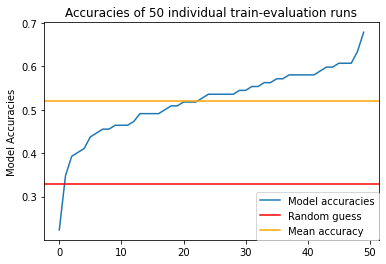

In [38]:
# plot accuracies
import matplotlib.pyplot as plt
plt.plot(sorted(accuracies), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=sum(accuracies)/runs, color='orange', linestyle='-', label='Mean accuracy')
plt.ylabel('Model Accuracies')
plt.title(f"Accuracies of {runs} individual train-evaluation runs")
plt.legend(loc="lower right", borderaxespad=0)
plt.savefig('plots/accuracies_deep04.png')
plt.show()

In [33]:

#load weights
path='saved_weights/deep_classifier_04.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference

In [34]:
def predict_sentence(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence
    return predict(model, tokenized)


def predict(model, tokenized):
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction
    return prediction

tens = predict_sentence(model, "Ich bin ein Lockdown.")


In [ ]:
#make predictions
sentence = "Ich bin ein Lockdown."
probs = predict_sentence(model, sentence)
label = LABEL.vocab.itos[torch.argmax(probs)]
print(sentence + " => " + label)

In [ ]:
# determine validation accuracy
correct = 0
total = 0
for e in valid_data:
    # print(getattr(e,'label'))
    # print(getattr(e, 'text'))
    target_label = getattr(e, 'label')
    tokenized_sentence = getattr(e, 'text')
    preds = predict(model, tokenized_sentence)
    pred_label = LABEL.vocab.itos[torch.argmax(preds)]
    if pred_label == target_label:
        correct += 1
    total += 1

accuracy = correct / total

In [ ]:

print(model)